In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re
import os

In [2]:
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import LowessSmoother

In [3]:
out_paths = r'D:\Data\air quality\bk air\train_data\output\*.csv'

In [4]:
out_paths = glob.glob(out_paths)

In [5]:
data_frames_out = []
for out_path in out_paths:
    data_out = pd.read_csv(out_path)
    data_out['station'] = out_path[54:-4]
    data_out.drop('Unnamed: 0', inplace=True, axis=1)
    data_frames_out.append(data_out)

In [6]:
path = r'D:\Data\air quality\bk air\train_data\input\*.csv'
file_paths = glob.glob(path)

In [7]:
data_frames = []
for file_path in file_paths:
    data = pd.read_csv(file_path)
    data['station'] = file_path[53:-4]
    data.drop('Unnamed: 0', inplace=True, axis=1)
    data_frames.append(data)

data_train = data_frames + data_frames_out

In [8]:
pm25_stations = pd.DataFrame()
for df in data_train:
    station = df['station'].unique()[0]
    pm25_stations[station] = df['PM2.5']

In [9]:
pm25_stations_dropna = pm25_stations.dropna(axis = 0, how = 'all')

In [10]:
pm25_stations_cl = pm25_stations_dropna.copy()

In [11]:
import xgboost
for station in pm25_stations.columns:
    col_nan_ix = pm25_stations_dropna[pm25_stations_dropna[station].isnull()].index
    test = pm25_stations_dropna[pm25_stations_dropna.index.isin(col_nan_ix)]
    train = pm25_stations_dropna.drop(col_nan_ix, axis = 0)
    
    train_inp = train.drop([station], axis = 1)
    train_tar = train[station]
    test_inp = test.drop([station], axis = 1)
    
    xgb_reg = xgboost.XGBRegressor()
    xgb_reg.fit(train_inp, train_tar)
    test_tar = xgb_reg.predict(test_inp)
    pm25_stations_cl[station][col_nan_ix] = test_tar

In [12]:
pm25_stations.loc[pm25_stations_cl.index] = pm25_stations_cl

In [13]:
pm25_stations = pm25_stations.interpolate(method='linear')

In [ ]:
pm25_stations

# Test file

In [14]:
def sort_list(path):
    return int(path[45:])

In [15]:
test_paths = r'D:\Data\air quality\bk air\public_test\input\*'
test_paths = glob.glob(test_paths)
test_paths.sort(key = sort_list)
station_diction = {}
for station in list(pm25_stations.columns)[:-4]:
    station_diction[station] = {}
station_diction
# go into the input sample
for test_path in test_paths:
    test_file_paths = glob.glob('{}\*.csv'.format(test_path))
    # go into station in each sample
    for test_file_path in test_file_paths:
        pattern = r"-[a-zA-Z0-9\s-]*.csv"
        matchs = re.search(pattern , test_file_path)
        station = matchs.group()[1:-4]
        
        station_dict_value = station_diction[station]
        data = pd.read_csv(test_file_path)
        # go into every row in data
        for idx in range(len(data)):
            pm25 = data.loc[idx, 'PM2.5']
            time = data.loc[idx, 'timestamp']
            if time not in station_dict_value:
                station_dict_value[time] = [pm25]
            else:
                station_dict_value[time].append(pm25)

In [16]:
for station in station_diction:
    for time in station_diction[station]:
        station_diction[station][time] = np.nanmean(station_diction[station][time])

C:\Users\ACER\AppData\Local\Temp/ipykernel_11120/3574001300.py:3: RuntimeWarning: Mean of empty slice
  station_diction[station][time] = np.nanmean(station_diction[station][time])


In [17]:
test_data_frames = {}
test_data_frames['timestamp'] = list(station_diction['Quan Hoa'].keys())
for key, value in station_diction.items():
    pm25 = list(value.values())
    test_data_frames[key] = pm25

In [18]:
concat_test_df_time =  pd.DataFrame.from_dict(test_data_frames)
concat_test_df = concat_test_df_time.drop(['timestamp'], axis = 1)

In [ ]:
concat_test_df_time

# Interpolation test and train

In [19]:
train_test_data_frame = pd.concat([pm25_stations.drop(list(pm25_stations.columns)[-4:], axis = 1), concat_test_df]).reset_index(drop = True)

In [ ]:
train_test_data_frame

In [57]:
##############################
# imputation train test concat
##############################
train_test_data_frame_cl = train_test_data_frame.copy()
for station in train_test_data_frame.columns:
    col_nan_ix = train_test_data_frame[train_test_data_frame[station].isnull()].index
    test = train_test_data_frame[train_test_data_frame.index.isin(col_nan_ix)]
    train = train_test_data_frame.drop(col_nan_ix, axis = 0)
    
    train_inp = train.drop([station], axis = 1)
    train_tar = train[station]
    test_inp = test.drop([station], axis = 1)
    
    xgb_reg = xgboost.XGBRegressor()
    xgb_reg.fit(train_inp, train_tar)
    test_tar = xgb_reg.predict(test_inp)
    train_test_data_frame_cl[station][col_nan_ix] = test_tar
#test_concat_cl = train_test_data_frame_cl[9000:].reset_index(drop = True)

In [20]:
####################################
# imputation train and test seprated
####################################
concat_test_df_cl = concat_test_df.copy()
for station in concat_test_df.columns:
    col_nan_ix = concat_test_df[concat_test_df[station].isnull()].index
    test = concat_test_df[concat_test_df.index.isin(col_nan_ix)]
    train = concat_test_df.drop(col_nan_ix, axis = 0)
    
    train_inp = train.drop([station], axis = 1)
    train_tar = train[station]
    test_inp = test.drop([station], axis = 1)
    
    xgb_reg = xgboost.XGBRegressor()
    xgb_reg.fit(train_inp, train_tar)
    test_tar = xgb_reg.predict(test_inp)
    concat_test_df_cl[station][col_nan_ix] = test_tar
test_concat_cl = concat_test_df_cl.copy()

In [21]:
test_concat_cl_time = test_concat_cl.copy()
test_concat_cl_time['timestamp'] = concat_test_df_time['timestamp']
test_concat_cl_time = test_concat_cl_time[list(test_concat_cl_time.columns)[-1:] + list(test_concat_cl_time.columns)[:-1]]

In [24]:
test_concat_cl_time

,timestamp,Ngoc Khanh,Thu vien - DHQG Ha Noi,Truong Tieu hoc Tran Quoc Toan,GENESIS School,Truong THCS Yen So,Quan Hoa,He thong lien cap Lomonoxop - Mam non,FDS - Ton That Thuyet,Hang Trong,Ba Trieu,Tran Quang Khai
0,06/06/2021 12:00,42.413170,79.976723,85.6,143.0,78.8,95.800000,86.8,107.5,60.1,54.40,83.3
1,06/06/2021 13:00,45.043644,75.395714,74.7,90.1,67.6,71.900000,79.2,96.6,59.0,58.30,76.0
2,06/06/2021 14:00,45.704380,80.585823,67.6,74.7,66.2,74.800000,82.2,101.5,53.8,59.60,84.9
3,06/06/2021 15:00,44.135830,69.120483,98.2,53.6,41.7,71.100000,52.6,71.1,71.9,61.80,106.2
4,06/06/2021 16:00,42.088066,75.655624,129.2,98.0,45.7,120.400000,71.0,110.3,97.6,83.30,126.8
...,...,...,...,...,...,...,...,...,...,...,...,...
2923,06/10/2021 07:00,8.900000,36.400000,26.1,53.4,50.3,44.240860,18.7,26.5,18.1,11.20,53.2
2924,06/10/2021 08:00,12.500000,38.100000,23.2,70.4,51.4,43.153969,21.8,29.5,16.6,9.70,52.9
2925,06/10/2021 09:00,13.400000,31.900000,22.3,61.8,53.1,42.034626,23.8,26.6,16.7,12.50,43.1
2926,06/10/2021 10:00,13.200000,37.100000,27.6,52.5,65.7,46.600000,28.5,33.7,29.8,20.95,58.1


# TRAIN

# Denoise the input data for train is pm25_stations_cl dataframe
# The input data frame for test is test_concat_cl dataframe
# your task is to denoise the data and feed it to the n-beat model

In [25]:
def fft_denoiser(x, n_components, to_real=True):
    """Fast fourier transform denoiser.
    
    Denoises data using the fast fourier transform.
    
    Parameters
    ----------
    x : numpy.array
        The data to denoise.
    n_components : int
        The value above which the coefficients will be kept.
    to_real : bool, optional, default: True
        Whether to remove the complex part (True) or not (False)
        
    Returns
    -------
    clean_data : numpy.array
        The denoised data.
        
    References
    ----------
    .. [1] Steve Brunton - Denoising Data with FFT[Python]
       https://www.youtube.com/watch?v=s2K1JfNR7Sc&ab_channel=SteveBrunton
    
    """
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

In [26]:
def outlier_detect(datas, length):
    data = datas.to_numpy()
    data = data[~np.isnan(data)]
    for i in range(len(data)):
        std = data[i:i+length].std()
        mean = data[i:i+length].mean()
        lower, upper = mean - 5*std, mean + 5*std
        filt = (datas > lower) & (datas < upper)
        datas[i:i+length][~filt] = np.nan
    return datas

In [27]:
def plot_data(features, raw_data, data_pre, window):
    num = len(features)
    ran = np.random.randint(0, len(raw_data) - window)
    for index, name in enumerate(features):
        y_raw = raw_data.loc[ran:ran+window, name]
        y = data_pre.loc[ran:ran+window, name]
        x = np.arange(0, len(y), 1)
        plt.figure(figsize=(25,12))
        plt.subplot(num//2 + 1, 2, index + 1)
        plt.plot(x,y, label = 'denoise', linewidth=2)
        plt.plot(x,y_raw, label = 'raw', linewidth=2)
        plt.legend()
        plt.title(name)
    return None

In [28]:
############################
#choosing feature to forcast
############################
#data = pm25_stations_cl.copy()
data = pm25_stations.copy()
features = list(pm25_stations_cl.columns)
input_data = data[features].interpolate(method='linear').copy()

In [29]:
# raw data to evaluate when preprocess, denoise, imputate input
###############################################################
data_hh = data[features].interpolate(method='linear').copy()
input_data_raw = data_hh.interpolate(method='linear')[features]

In [30]:
# max min rescale input
###########################
input_data_cop = input_data.copy()
for columns in input_data.columns:
    max = input_data[columns].max()
    min = input_data[columns].min()
    input_data.loc[:, columns] = (input_data[columns] - min)/(max - min)
    input_data_raw.loc[:, columns] = (input_data_raw[columns] - min)/(max - min)

In [31]:
# max min rescale test
###########################
test_concat_cl_cop = test_concat_cl.copy()
for columns in test_concat_cl.columns:
    max = input_data_cop[columns].max()
    min = input_data_cop[columns].min()
    test_concat_cl.loc[:, columns] = (test_concat_cl[columns] - min)/(max - min)

In [32]:
test_concat_cl_time[list(test_concat_cl.columns)] = test_concat_cl

In [33]:
test_concat_cl_time

,timestamp,Ngoc Khanh,Thu vien - DHQG Ha Noi,Truong Tieu hoc Tran Quoc Toan,GENESIS School,Truong THCS Yen So,Quan Hoa,He thong lien cap Lomonoxop - Mam non,FDS - Ton That Thuyet,Hang Trong,Ba Trieu,Tran Quang Khai
0,06/06/2021 12:00,0.153701,0.301366,0.313988,0.533097,0.289879,0.413743,0.393480,0.427699,0.219412,0.230446,0.308251
1,06/06/2021 13:00,0.163482,0.284523,0.273438,0.333911,0.248282,0.309336,0.358586,0.383892,0.215322,0.244367,0.281058
2,06/06/2021 14:00,0.165939,0.303605,0.247024,0.275924,0.243083,0.322004,0.372360,0.403585,0.195984,0.249007,0.314211
3,06/06/2021 15:00,0.160106,0.261452,0.360863,0.196476,0.152089,0.305841,0.236455,0.281408,0.263295,0.256860,0.393556
4,06/06/2021 16:00,0.152492,0.285479,0.476190,0.363657,0.166945,0.521209,0.320937,0.438952,0.358869,0.333601,0.470292
...,...,...,...,...,...,...,...,...,...,...,...,...
2923,06/10/2021 07:00,0.029079,0.141153,0.092634,0.195723,0.184030,0.188506,0.080808,0.102162,0.063221,0.076250,0.196126
2924,06/10/2021 08:00,0.042466,0.147403,0.081845,0.259733,0.188115,0.183758,0.095041,0.114219,0.057642,0.070896,0.195008
2925,06/10/2021 09:00,0.045813,0.124608,0.078497,0.227351,0.194429,0.178868,0.104224,0.102564,0.058014,0.080890,0.158503
2926,06/10/2021 10:00,0.045069,0.143726,0.098214,0.192334,0.241226,0.198812,0.125803,0.131099,0.106731,0.111051,0.214379


# Rolling + FFT

In [ ]:
######################
# denoise training set
######################
rolling = 10
data_pre = input_data_raw.copy()
for feature in features[:-4]:
    x = data_pre[feature]
    x = x.rolling(rolling).mean().dropna(axis = 0, how = 'all')
    x = x.to_numpy()
    x = fft_denoiser(x, 0.0005)
    data_pre.loc[rolling - 1: ,feature] = x

In [ ]:
##############################
# Denoise test set input
##############################
rolling = 10
test_data_pre = test_concat_cl.copy()
for feature in features[:-4]:
    x = test_data_pre[feature]
    x = x.rolling(rolling).mean().dropna(axis = 0, how = 'all')
    x = x.to_numpy()
    x = fft_denoiser(x, 0.0005)
    test_data_pre.loc[rolling - 1: ,feature] = x

# Smoothing + FFT

In [51]:
##################################################
# denoise training set to avoid lake of ram memory
##################################################
# smothing part
data_pre = input_data_raw.copy()
list_denoise = []
for idx in range(len(data_pre))[::3000]:
    data = data_pre.iloc[idx:idx+3000, :]
    data = data.to_numpy().transpose()
    smoother = LowessSmoother(smooth_fraction=0.05, iterations=1)
    smoother.smooth(data)
    list_denoise.append(smoother.smooth_data.transpose())
data_pre.iloc[:, :] = np.concatenate(list_denoise, axis = 0)
# fft transform part
for feature in features[:]:
    x = data_pre[feature]
    x = x.to_numpy()
    x = fft_denoiser(x, 0.001)
    data_pre.loc[: ,feature] = x

In [47]:
#########################
# Denoise test set input
########################
test_data_pre = test_concat_cl.copy()
data = test_data_pre.to_numpy().transpose()
smoother = LowessSmoother(smooth_fraction=0.05, iterations=2)
smoother.smooth(data)
test_data_pre[:] = smoother.smooth_data.transpose()
for feature in features[:-4]:
    x = test_data_pre[feature]
    x = x.to_numpy()
    #x = fft_denoiser(x, 0.001)
    test_data_pre.loc[: ,feature] = x

# Visualize raw and denoise data

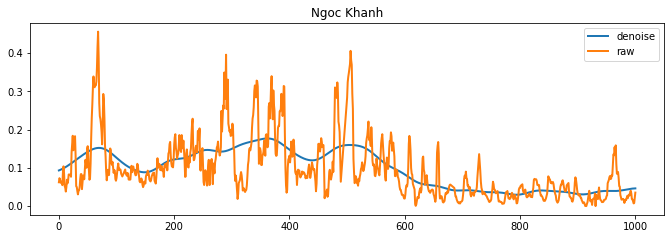

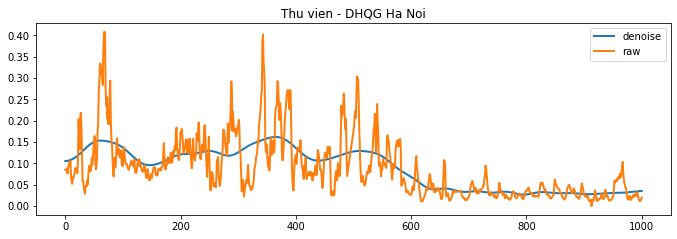

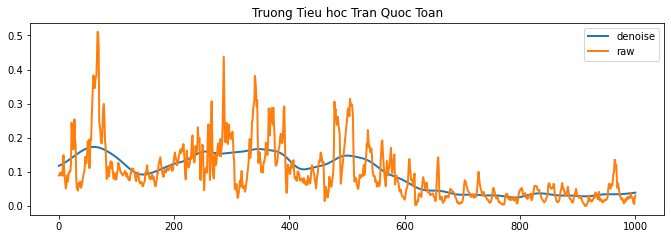

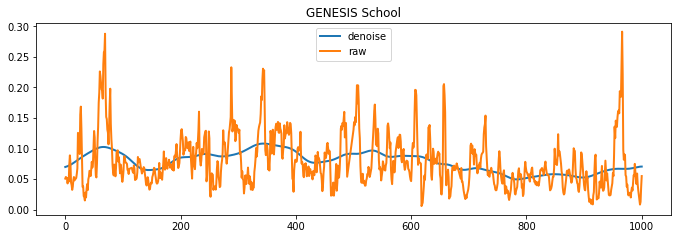

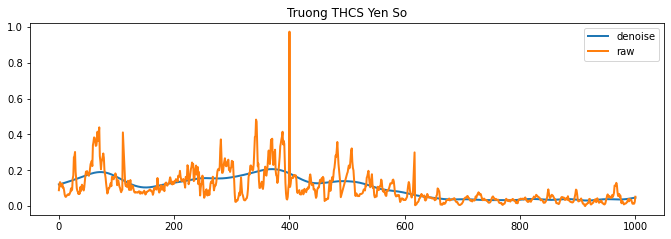

In [52]:
############################
# plot raw and denoise input
############################
plot_data(features[:5], input_data_raw, data_pre, 1000)

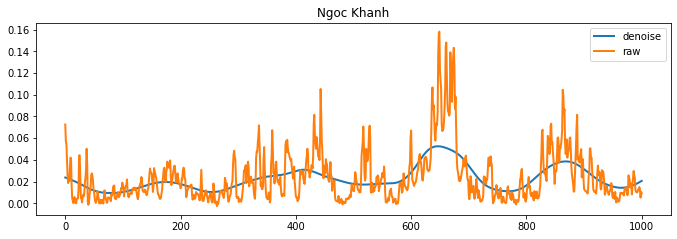

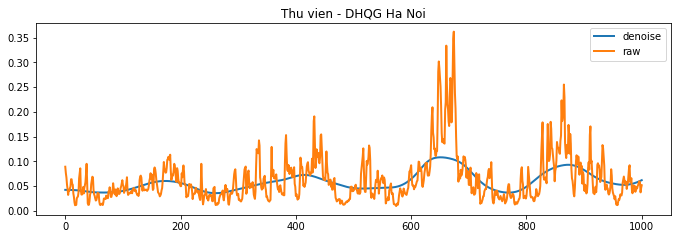

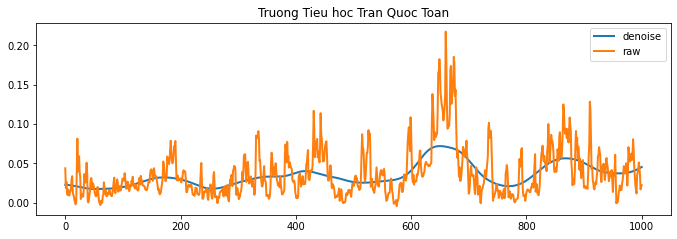

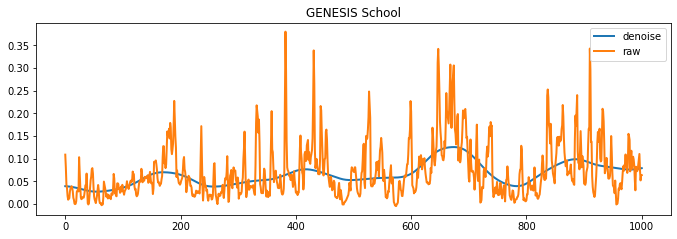

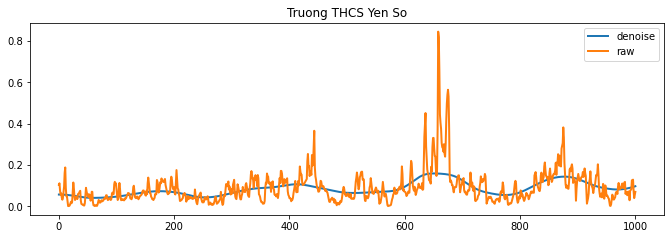

In [48]:
##########################
#plot raw and denoise test
##########################
plot_data(features[:5], test_concat_cl, test_data_pre, 1000)

# Prepare data for training

In [53]:
station_idx = 11
y_true = input_data_raw[features[station_idx]].to_numpy()
y_pre = data_pre[features[station_idx]].to_numpy()
error = tf.keras.losses.MeanAbsoluteError()(y_true, y_pre).numpy()
print('the error of denoise and clean data is', error)
print('the percent out different is:', error/y_true.mean()*100, '%')

the error of denoise and clean data is 0.053538691252470016
the percent out different is: 31.35287776009399 %


In [85]:
################################################################
# split the train, valid, and test set in ratio 0.95, 0.05, 0.05
# and change to the numpy form
###############################################################
input_data = data_pre
#train
train_data = input_data.loc[:int(len(input_data)*0.9)]
train_data = train_data.reset_index(drop = True)
#valid
valid_data = input_data.loc[int(len(input_data)*0.9):]
valid_data = valid_data.reset_index(drop = True)
#test
test_data = input_data.loc[int(len(input_data_raw)*0.7):]
test_data = test_data.reset_index(drop = True)


window_size = 24*7*2
horizontal_size = 24

window_len = window_size + horizontal_size # include window and horizontal
list_train = []
list_valid = []
list_test = []
for i in range(len(train_data)):
    list_train.append(list(train_data.loc[i]))
for i in range(len(valid_data)):
    list_valid.append(list(valid_data.loc[i]))
for i in range(len(test_data)):
    list_test.append(list(test_data.loc[i]))

train_input = np.array(list_train)
valid_input = np.array(list_valid)
test_input = np.array(list_test)

In [55]:
###################################
# prepare batch data for output file
###################################
test_concat_cl = test_data_pre
test_final_input = []
for test_path in test_paths:
    test_file_paths = glob.glob('{}\*.csv'.format(test_path))
    # go to one station to take the time period in that station
    times = pd.read_csv(test_file_paths[0])['timestamp']
    list_idx = []
    for time in times:
        idx = test_concat_cl_time['timestamp'] == time
        list_idx.append(list(idx[idx].index)[0])
    final_station_data = test_concat_cl.loc[list_idx].to_numpy().tolist()
    test_final_input.append(final_station_data)
test_final_input = np.array(test_final_input)

In [86]:
#######################################################
############################## test!!!!!!!!!!!!!!!!!!!!
# test input with horizon more than 7 day
########################################################
test_concat_cl_time = test_concat_cl_time.reset_index(drop = True)
train_test_data_frame_cl_cop = train_test_data_frame_cl.copy()
train_test_data_frame_cl_cop[9000:] = test_data_pre
test_concat_cl_time.index += 9000
test_final_input = []
for test_path in test_paths:
    test_file_paths = glob.glob('{}\*.csv'.format(test_path))
    # go to one station to take the time period in that station
    times = pd.read_csv(test_file_paths[0])['timestamp']
    idx = test_concat_cl_time['timestamp'] == list(times)[-1] # last timestamp
    idx = list(idx[idx].index)[0] # take the idx
    # take data according to window_size
    final_station_data = train_test_data_frame_cl_cop.loc[idx-window_size+1:idx].to_numpy().tolist()
    test_final_input.append(final_station_data)
test_final_input = np.array(test_final_input)

In [59]:
################################################################################
#split the input and target and change the tf.data.Dataset form for better speed
################################################################################
future_look = horizontal_size# or it mean horizontal
station = -4
def preprocess(data):
    data = tf.data.Dataset.from_tensor_slices(data)
    data = data.window(window_len, shift = 1, drop_remainder = True)
    data = data.flat_map(lambda window: window.batch(window_len))
    data = data.batch(32).shuffle(1000)
    data = data.map(lambda window: (window[:, :-future_look, :-4], window[:, -future_look:, station]))
    data.prefetch(tf.data.AUTOTUNE)
    return data

In [116]:
#type 1
station = -1
train_data = preprocess(train_input)
valid_data = preprocess(valid_input)
test_data = preprocess(test_input)

In [ ]:
for x,y in train_data.take(1):
    print(x.shape)
    print(y.shape)

# Model

In [61]:
class Time2Vector(keras.layers.Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:3], axis=-1)
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)

In [62]:
#################################
# custom n-beat model
################################
class n_beat_block(tf.keras.layers.Layer):
    def __init__(self, n_neurons, n_layers, window, horizontal, **kwargs):
        super().__init__(**kwargs)
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        self.window = window
        self.horizontal = horizontal
        theta_size = window + horizontal
        self.hidden_layers = [keras.layers.Dense(n_neurons, activation = 'relu') for _ in range(n_layers)]
        self.theta_layer = keras.layers.Dense(theta_size, activation = 'linear')
    
    def call(self, inputs):
        x = self.hidden_layers[0](inputs)
        for layer in self.hidden_layers[1:]:
            x = layer(x)
        theta = self.theta_layer(x)
        backcast, forecast = theta[:, :self.window], theta[:, -self.horizontal:]
        return backcast, forecast

class nbeat(tf.keras.layers.Layer):
    def __init__(self, n_neurons, n_layers, window, horizontal, **kwargs):
        super().__init__(**kwargs)
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        self.window = window
        self.horizontal = horizontal
        self.flatten = keras.layers.Flatten()
        self.hidden = [keras.layers.Dense(n_neurons, activation = 'relu') for _ in range(n_layers)]
        self.theta = keras.layers.Dense(window + horizontal, activation = 'linear')
        
    def call(self, inputs):
        x = inputs
        x = self.flatten(x)
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta(x)
        #squeeze = keras.layers.Lambda(lambda x: tf.squeeze(x))(theta)
        #backcast, forecast = squeeze[:, :window], squeeze[:, -horizontal:]
        backcast, forecast = theta[: , :self.window], theta[:, -self.horizontal:]
        return backcast, forecast

def build_nbeat(n_block = 10, n_neurons = 64, n_layers = 4, window = 60, horizontal = 7, feature = 4):
    inputs = keras.layers.Input(shape = (window, feature))
    time = Time2Vector(window)(inputs)
    concat = keras.layers.Concatenate(axis = -1)([inputs, time])
    nbeat_block = nbeat(n_neurons = n_neurons,
                        n_layers = n_layers,
                        window = window,
                        horizontal = horizontal)
    backcast, forecast = nbeat_block(concat)

    for _ in range(n_block):

        block_backcast, block_forecast = n_beat_block(n_neurons = n_neurons,
                                                      n_layers = n_layers,
                                                      window = window,
                                                      horizontal = horizontal)(backcast)

        forecast = keras.layers.add([forecast, block_forecast])
        backcast = keras.layers.subtract([backcast, block_backcast])

    model = keras.Model(inputs = inputs, outputs = forecast)
    return model

In [117]:
model = build_nbeat(n_block = 5, n_neurons = 32, n_layers = 4, window = window_size, feature = 11, horizontal = 24)

# LSTM

In [ ]:
##########################
# LSTM
##########################
inputs = keras.layers.Input(shape = [None, 11])
z1 = keras.layers.LSTM(128, return_sequences = True)(inputs)
z2 = keras.layers.LSTM(128, return_sequences = True)(z1)
z3 = keras.layers.concatenate([z1, z2])
z4 = keras.layers.LSTM(128)(z3)
outputs = keras.layers.Dense(future_look, activation = 'sigmoid')(z4)
model = keras.Model(inputs = [inputs], outputs = [outputs])

In [64]:
def mean_square_error_2(y_true, y_pred):
    min = input_data_cop[features[station]].min()
    max = input_data_cop[features[station]].max()
    y_true = tf.math.add(tf.math.multiply(y_true, max - min), min)
    y_pred = tf.math.add(tf.math.multiply(y_pred, max - min), min)
    acc = tf.reduce_mean(tf.math.pow(y_true - y_pred, 2), axis = -1)
    return acc

In [65]:
def mean_absolute_error_2(y_true, y_pred):
    min = input_data_cop[features[station]].min()
    max = input_data_cop[features[station]].max()
    y_true = tf.math.add(tf.math.multiply(y_true, max - min), min)
    y_pred = tf.math.add(tf.math.multiply(y_pred, max - min), min)
    acc = tf.reduce_mean(tf.math.abs(y_true - y_pred), axis = -1)
    return acc

In [118]:
tf.random.set_seed(42)
optimizer = keras.optimizers.Adam(learning_rate=3e-4) # learning rate = 3e-4 for multi feature and 1e-2 for one feature
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer,
              #metrics=[tf.keras.metrics.MeanSquaredError()]
              metrics=[mean_square_error_2, mean_absolute_error_2]
              )
early_stoppping = keras.callbacks.EarlyStopping(patience = 10,
                                               restore_best_weights = True)
history = model.fit(train_data,
                    validation_data = valid_data,
                    epochs = 200,
                    callbacks = [early_stoppping]
                   )

Epoch 1/200
242/242 [==============================] - 13s 34ms/step - loss: 0.0064 - mean_square_error_2: 913.4648 - mean_absolute_error_2: 22.2364 - val_loss: 7.2005e-04 - val_mean_square_error_2: 103.3567 - val_mean_absolute_error_2: 8.8791
Epoch 2/200
242/242 [==============================] - 11s 30ms/step - loss: 0.0033 - mean_square_error_2: 473.1162 - mean_absolute_error_2: 16.6213 - val_loss: 2.8047e-04 - val_mean_square_error_2: 40.2593 - val_mean_absolute_error_2: 5.4636
Epoch 3/200
242/242 [==============================] - 10s 29ms/step - loss: 0.0027 - mean_square_error_2: 382.9071 - mean_absolute_error_2: 14.5910 - val_loss: 3.5790e-04 - val_mean_square_error_2: 51.3731 - val_mean_absolute_error_2: 6.2262
Epoch 4/200
242/242 [==============================] - 10s 30ms/step - loss: 0.0022 - mean_square_error_2: 311.8348 - mean_absolute_error_2: 13.3919 - val_loss: 7.2186e-04 - val_mean_square_error_2: 103.6167 - val_mean_absolute_error_2: 8.8523
Epoch 5/200
242/242 [=====

In [119]:
output = model.predict(test_final_input)

In [120]:
min = input_data_cop[features[station]].min()
max = input_data_cop[features[station]].max()
output = (output * (max - min)) + min

In [121]:
for idx, result in enumerate(output):
    data_frame_result = pd.DataFrame()
    data_frame_result['PM2.5'] = result
    file_path = r'D:\Data\air quality\bk air\try\prediction\{}'.format(idx+1)
    os.makedirs(file_path, exist_ok=True)
    foler_path = os.path.join(file_path, 'res_{}_2.csv'.format(idx+1))
    data_frame_result.to_csv(foler_path)

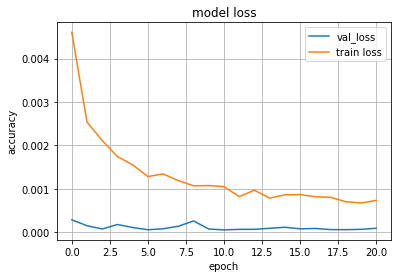

In [112]:
#plt.plot(history.history['val_mean_absolute_error_2'])
#plt.plot(history.history['mean_absolute_error_2'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
#plt.legend(['mae valid', 'mae train', 'val_loss', 'train loss'])
plt.legend(['val_loss', 'train loss'])
plt.show()

In [95]:
##### just for training
error = model.evaluate(test_data)
print('loss of the test set is:', error[0])
print('mse of the test set is:', error[1])
print('mae of the test set is:', error[2])

74/74 [==============================] - 2s 15ms/step - loss: 4.1416e-04 - mean_square_error_2: 59.9287 - mean_absolute_error_2: 6.1360
loss of the test set is: 0.0004141570534557104
mse of the test set is: 59.9287223815918
mae of the test set is: 6.135951995849609


In [122]:
def plot_result(dataset, look):
    position = np.random.randint(0, 32)
    for x,y in dataset.take(1):
        y_pred = model.predict(x)[position]
        y_true = y[position]
        x_inp = x[position, :, station]
        y_true = np.concatenate((x_inp[-look:], y_true))
        y_pred = np.concatenate((x_inp[-look:], y_pred))
        plt.plot(y_true, label = 'raw')
        plt.plot(y_pred, label = 'pred')
        plt.legend()
        plt.show()
    return None

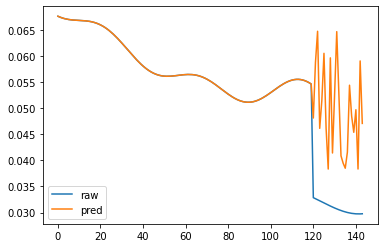

In [130]:
plot_result(test_data, 120)